In [ ]:
import io
import requests
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, cross_validate, 
                                     GridSearchCV)
from sklearn.linear_model import (LinearRegression, Ridge,
                                  Lasso, ElasticNet)
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ManualAlphaSelection

# Make this notebook's output stable across runs
np.random.seed(100)

# Do not use scientific notation in pandas tables
pd.options.display.float_format = '{:,.4f}'.format

In [ ]:
url = 'https://raw.githubusercontent.com/natecraig/aiml/main/Data/closings.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head(-1)

,StoreType,LiquidationRevenue,InventoryAtTicket,LastYearRevenue,MedianHouseholdIncome,MedianAge
0,Bookstore,"1,214,776.2000","2,195,069.8000","465,237.3000",51290,37.8000
1,Bookstore,"1,811,896.9000","3,152,301.9000","897,704.5000",46702,33.4000
2,Bookstore,"1,157,614.7000","2,229,837.5000","477,804.8000",86804,41.7000
3,Bookstore,"2,037,136.2000","3,857,466.8000","1,036,097.7000",83544,40.3000
4,Bookstore,"1,326,821.1000","2,345,263.8000","612,793.5000",23508,31.9000
...,...,...,...,...,...,...
557,Household Goods,"1,637,960.5000","2,355,014.5300","1,574,261.7000",68264,33.1000
558,Household Goods,"1,527,890.1000","2,332,591.8000","1,574,261.7000",41808,38.3000
559,Household Goods,"2,209,627.2000","2,487,114.6300","1,669,047.6000",40330,28.3000
560,Household Goods,"1,631,831.3000","2,267,342.3300","1,574,261.7000",46960,38.2000


In [ ]:
# Transform features - binary dummy variables
df['Bookstore'] = df['StoreType'].apply(lambda x: 1 if x == 'Bookstore' else 0)
df['BookstoreXInventoryAtTicket'] = df['Bookstore'] * df['InventoryAtTicket']

In [ ]:
# Add square terms
numvars = ['InventoryAtTicket', 'LastYearRevenue', 'MedianHouseholdIncome']
for v in numvars:
    df[v + 'Sq'] = df[v]**2

In [ ]:
# Set the target, y, and features, X
y = df['LiquidationRevenue']

feature_names = ['Bookstore', 'BookstoreXInventoryAtTicket',
                 'InventoryAtTicket', 'InventoryAtTicketSq',
                 'MedianHouseholdIncome', 'MedianHouseholdIncomeSq',
                 'LastYearRevenue', 'LastYearRevenueSq']
X = df[feature_names]

In [ ]:
# Scale data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# Split data into training and test sets
(X_train, X_test,
 y_train, y_test) = train_test_split(X_scale, y, test_size=0.75)

In [ ]:
# Fit a linear regresion
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# y values based on x_train
y_train_pred = linreg.predict(X_train)
# y values based on x_test
y_pred = linreg.predict(X_test)

In [ ]:
# Retain coefficients and performance
# create new table and add column names
df_regs = pd.DataFrame(columns=(['Intercept'] + feature_names
                                + ['Train R2', 'Test R2', 'AverageR2']))

scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)]
# populate columns with linreg data
df_regs.loc['Linear'] = ([linreg.intercept_] + list(linreg.coef_)
                         + [r2_score(y_train, y_train_pred),
                            r2_score(y_test, y_pred), np.mean(scores)])


In [ ]:
# Set regularization parameter for ridge, lasso, and elasticnet
# balance fit of model to training data WITH magnitude of parameters
# slope is function that is being optimized 

alpha=2
l1_ratio=0.5

In [ ]:
# Ridge: reduce slope of line close to zero
# minimize ((theta)^2)

ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)]

df_regs.loc['Ridge'] = ([ridge.intercept_] + list(ridge.coef_)
                         + [r2_score(y_train, y_train_pred),
                            r2_score(y_test, y_pred), np.mean(scores)])

In [ ]:
# Lasso: reduce slope of line to zero
# minimize (|theta|)

lasso = Lasso(alpha=alpha, max_iter=100000)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)]

df_regs.loc['Lasso'] = ([lasso.intercept_] + list(lasso.coef_)
                         + [r2_score(y_train, y_train_pred),
                            r2_score(y_test, y_pred), np.mean(scores)])

In [ ]:
# Elastic Net
# hybrid, minimize both
# (a/2)(1-b)

elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
elastic.fit(X_train, y_train)
y_train_pred = elastic.predict(X_train)
y_pred = elastic.predict(X_test)

scores = [r2_score(y_train, y_train_pred), r2_score(y_test, y_pred)]

df_regs.loc['ElasticNet'] = ([elastic.intercept_] + list(elastic.coef_)
                             + [r2_score(y_train, y_train_pred),
                                r2_score(y_test, y_pred), np.mean(scores)])

In [ ]:
df_regs

,Intercept,Bookstore,BookstoreXInventoryAtTicket,InventoryAtTicket,InventoryAtTicketSq,MedianHouseholdIncome,MedianHouseholdIncomeSq,LastYearRevenue,LastYearRevenueSq,Train R2,Test R2,AverageR2
Linear,"1,756,550.2274","257,912.6281","-236,810.8758","654,008.7940","-472,022.3060","198,559.2980","-202,674.6639","546,420.6269","-83,172.0186",0.9367,0.8971,0.9169
Ridge,"1,770,840.7882","-118,066.6317","36,693.6042","182,910.7247","-40,990.2177","98,188.8457","-95,337.2392","338,160.1661","79,932.8048",0.9316,0.9160,0.9238
Lasso,"1,756,593.4641","256,183.6087","-235,401.9346","651,943.3559","-470,313.8183","198,404.3636","-202,499.6174","546,115.5006","-82,887.0992",0.9367,0.8972,0.9170
ElasticNet,"1,768,988.0107","-84,414.4636","-63,071.8148","95,415.2206","84,111.3136","10,959.9097",160.6739,"118,546.0410","100,952.4237",0.8728,0.8687,0.8707


**Question 1.** The Ridge regularization method performs the best for this model, since its average r^2 value is the highest among the regularization models. The high r^2 value shows that the independent features/variables in this model can measure a higher proportion of the variability in Liquidation Revenue than any of the other models. The performance of this model can be characterized by the highest r^2 value amongst the models, as this shows that ridge regularization provides a better fit by reducing overfitting but maintaing generalization properties.



---



**Question 2.** The best performance of the model can be determined by the best alpha and l1_ratio, which can be found using cross-validation. Using ManualAlphaSelection and a visualizer can show the performance of the model, or r^2, which has an inverse relationship with alpha and decreases as the alpha increases. As such, the performance of the model is currently optimized with the current alpha = 1, since alpha values can only be positive. 

Citation: [Sci-kit docs](https://www.scikit-yb.org/en/latest/api/regressor/alphas.html)

In [ ]:
# Create a list of alphas to cross-validate against
alphas = np.linspace(0.1, 5, 20)

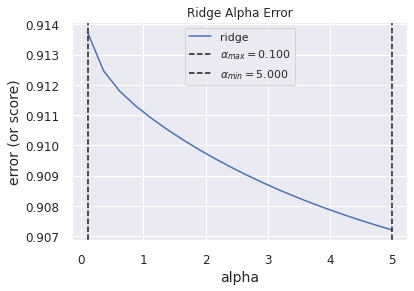

In [ ]:
# Instantiate the visualizer with 10 fold cross validation
visualizer = ManualAlphaSelection(
    # ridge model that was created earlier
    ridge,
    alphas=alphas,
    cv=10,
    scoring="r2"
)

visualizer.fit(X_train, y_train)
visualizer.show()

**Question 2.** The alpha and l1_ratio used in elastic net regularization can be optimized by using grid-search and 10 fold cross-validation with r^2 as the scoring. The best parameters then found are 0.1 for alpha, and 1.0 for l1_ratio.

In [ ]:
# Create a list of l1 values to cross-validate against
l1 = np.linspace(0.1, 1, 20)

In [ ]:
parameters = {
    'alpha':alphas,
    'l1_ratio':l1
}

In [ ]:
# create a grid search object
grid = GridSearchCV(elastic, param_grid=parameters, cv= 10, scoring='r2')

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
bestParam = grid.best_params_
bestR2Score = grid.best_score_

print("Best Parameters: ", bestParam)
print("Best r2 score: ", bestR2Score)

Best Parameters:  {'alpha': 0.1, 'l1_ratio': 1.0}
Best r2 score:  0.9142403729474115


**Question 2.** After cross-validating values of alpha and l1_ratio, the most optimized performance of the elastic net model can be characterized by an r^2 score of 0.9142. This score is less than the optimal score obtained from the ridge model, which is why the ridge model has the best performance. 



---



**Question 3.** Predicted Revenue for new store: $2261745.4497106927

In [ ]:
# 0 & 0 for household and householdxticket
New_store = [[
    0, 0,
    3_100_000, 3_100_000**2,
    75_000, 75_000**2,
    1_700_000, 1_700_000**2
]]

New_store_scaled = scaler.transform(New_store)
New_store_scaled_list = New_store_scaled.tolist()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
parameters = list(ridge.coef_)
parameters

[-118066.63166192904,
 36693.60422644846,
 182910.72467400532,
 -40990.217706307434,
 98188.84570482522,
 -95337.23921601677,
 338160.1660642377,
 79932.80482283818]

In [ ]:
New_store_scaled_list

[[-0.7336561634173181,
  -0.6948894948951552,
  0.8491048949384383,
  0.8268622790389044,
  0.9693551089200414,
  0.801698614272516,
  0.741163993297871,
  0.4877216204656339]]

In [ ]:
print(type(New_store_scaled_list))
print(type(parameters))

<class 'list'>
<class 'list'>


In [ ]:
New_store_scaled_list = np.array(New_store_scaled_list).astype(np.float64)

total = np.sum(New_store_scaled_list * parameters)

pred_rev = ridge.intercept_ + total

print(f"Predicted Revenue for new store: ${pred_rev}")

Predicted Revenue for new store: $2261745.4497106927




---



**Question 4.** A bias that could exist in the model would be in the median household income data, since data collected in lower-income areas would post a lower median income, which would then impact the liquidation revenue value of the business. A business that is successful for its area would have a lower value than a business that is less successful in a higher income area.

Another bias could be the time this data was collected. It is possible that the business reported a low revenue last year, but its revenue this was higher than other stores in the sample. Due to this, a store that might be doing better right now may report a lower liquidation revenue value than a store that is doing poorer right now, but did well last year. 

A bias can also occur with the inventory value - a store that was in the middle of an inventory cycle or in the process of replenishment would report a lower value than a store that recently restocked its inventory. Therefore, stores could report a lower overall value due to the timing of the data collection.